In [248]:
import pandas as pd
import numpy as np
import random
import torch
import os
def custom_set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
custom_set_seed(0)
df = pd.read_csv("combined_dataset.csv")
#df = df.drop(columns = "Unnamed: 0")
df = df.iloc[58:]
df['Date'] = pd.to_datetime(df['Unnamed: 0']).dt.date
df['Time'] = pd.to_datetime(df['Unnamed: 0']).dt.time
df = df.drop(columns = "Unnamed: 0")
df = df[df['Date'] != pd.to_datetime('2023-04-26').date()]
data_dict = {}
for date, group in df.groupby('Date'):
    data_dict[date] = group.drop(columns=['Date', 'Time']).to_numpy()

# Create a list to store the unique times
unique_times = df['Time'].unique()

# Create a 3D NumPy array
num_dates = len(data_dict)
list_copy = list(data_dict.keys())[:]
random.shuffle(list_copy)

train_dates = list_copy[:192]
train_dates.sort()

test_dates = list_copy[192:]
test_dates.sort()

train_dict={}
for date in train_dates:
    train_dict[date] = data_dict[date]
test_dict={}
for date in test_dates:
    test_dict[date] = data_dict[date]

num_times = len(unique_times)

num_features = len(df.columns) - 2  # Subtract 2 for Date and Time columns

train_set = np.zeros((len(train_dates), num_times, num_features))

date_index_mapping = {date: i for i, date in enumerate(train_dict.keys())}
time_index_mapping = {time: j for j, time in enumerate(unique_times)}

for date, time_values in train_dict.items():
        for time, values in zip(df[df['Date'] == date]['Time'], time_values):
            i = date_index_mapping[date]
            j = time_index_mapping[time]
            train_set[i, j, :] = values

test_set = np.zeros((len(test_dates), num_times, num_features))

date_index_mapping = {date: i for i, date in enumerate(test_dict.keys())}
time_index_mapping = {time: j for j, time in enumerate(unique_times)}

for date, time_values in test_dict.items():
        for time, values in zip(df[df['Date'] == date]['Time'], time_values):
            i = date_index_mapping[date]
            j = time_index_mapping[time]
            test_set[i, j, :] = values



In [249]:
import pandas as pd
daily = pd.read_csv("daily_dataset.csv")
daily['SENTIMENT_Neg'] = daily['SENTIMENT_Neg'].fillna(0)
daily['SENTIMENT_Neu'] = daily['SENTIMENT_Neu'].fillna(1)
daily['SENTIMENT_Pos'] = daily['SENTIMENT_Pos'].fillna(0)
daily = daily.iloc[1:]
daily['Date'] = pd.to_datetime(daily['Unnamed: 0']).dt.date
daily = daily.drop(columns = "Unnamed: 0")
train_daily = daily[daily['Date'].isin(train_dates)].drop(columns = "Date")
test_daily = daily[~daily['Date'].isin(train_dates)].drop(columns = "Date")


In [250]:
import pandas as pd
y = pd.read_csv("target_dataset.csv")
y['Date'] = pd.to_datetime(y['Unnamed: 0']).dt.date
y = y.drop(columns = "Unnamed: 0")
y_train = y[y['Date'].isin(train_dates)].drop(columns = "Date")
y_test = y[y['Date'].isin(test_dates)].drop(columns = "Date")
print(len(y_train))
print(len(y_test))

192
48


In [251]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

main_input = Input(shape=(79, 112))  
lstm_out = LSTM(64, return_sequences=True)(main_input)  # Using return_sequences=True for attention


attention_out = MultiHeadAttention(num_heads=4, key_dim=64)(lstm_out, lstm_out)


attention_out = LayerNormalization()(attention_out)
attention_out = Dropout(0.05)(attention_out)


attention_lstm_out = LSTM(32, return_sequences=False)(attention_out)


additional_input = Input(shape=(1, 13))  
additional_lstm_out = LSTM(32, return_sequences=False)(additional_input)


merged = Concatenate()([attention_lstm_out, additional_lstm_out])


dense_out = Dense(16, activation='relu')(merged)
output = Dense(1, activation='linear')(dense_out)  


model = Model(inputs=[main_input, additional_input], outputs=output)


model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
train_daily_array = train_daily.to_numpy().reshape(192, 1, 13)
train_set = train_set.astype('float32')
train_daily_array = train_daily_array.astype('float32')
y_train = y_train.astype('float32')
scaler1 = StandardScaler()
scaler2 = StandardScaler()

train_set_scaled = scaler1.fit_transform(train_set.reshape(-1, train_set.shape[-1])).reshape(train_set.shape)
train_daily_scaled = scaler2.fit_transform(train_daily_array.reshape(-1, train_daily_array.shape[-1])).reshape(train_daily_array.shape)
# Train the model
model.fit([train_set, train_daily_array], y_train, epochs=200, batch_size=8)


Epoch 1/200
24/24 [==============================] - 3s 21ms/step - loss: 0.0096
Epoch 2/200
24/24 [==============================] - 1s 21ms/step - loss: 3.8162e-05
Epoch 3/200
24/24 [==============================] - 1s 21ms/step - loss: 1.3504e-05
Epoch 4/200
24/24 [==============================] - 1s 21ms/step - loss: 9.9632e-06
Epoch 5/200
24/24 [==============================] - 1s 21ms/step - loss: 1.1260e-05
Epoch 6/200
24/24 [==============================] - 1s 21ms/step - loss: 1.0016e-05
Epoch 7/200
24/24 [==============================] - 1s 21ms/step - loss: 9.1947e-06
Epoch 8/200
24/24 [==============================] - 1s 21ms/step - loss: 8.3345e-06
Epoch 9/200
24/24 [==============================] - 1s 21ms/step - loss: 7.8601e-06
Epoch 10/200
24/24 [==============================] - 1s 21ms/step - loss: 1.0097e-05
Epoch 11/200
24/24 [==============================] - 1s 21ms/step - loss: 6.2323e-06
Epoch 12/200
24/24 [==============================] - 1s 21ms/step 

In [252]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Reshape and convert test data types
test_daily_array = test_daily.to_numpy().reshape(48, 1, 13)

# Convert back to original shape if necessary
test_daily_array_scaled = test_daily_array.reshape(48, 1, 13)
test_set_scaled = test_set.astype('float32')
test_daily_array_scaled = test_daily_array_scaled.astype('float32')
y_test = y_test.astype('float32')

# Make predictions with the model
predictions = model.predict([test_set_scaled, test_daily_array_scaled])

# Calculate metrics
mse = mean_squared_error(y_test, predictions)
r_squared = r2_score(y_test, predictions)


print("Mean Squared Error:", mse)

2/2 [==============================] - 1s 14ms/step
Mean Squared Error: 5.918532e-08


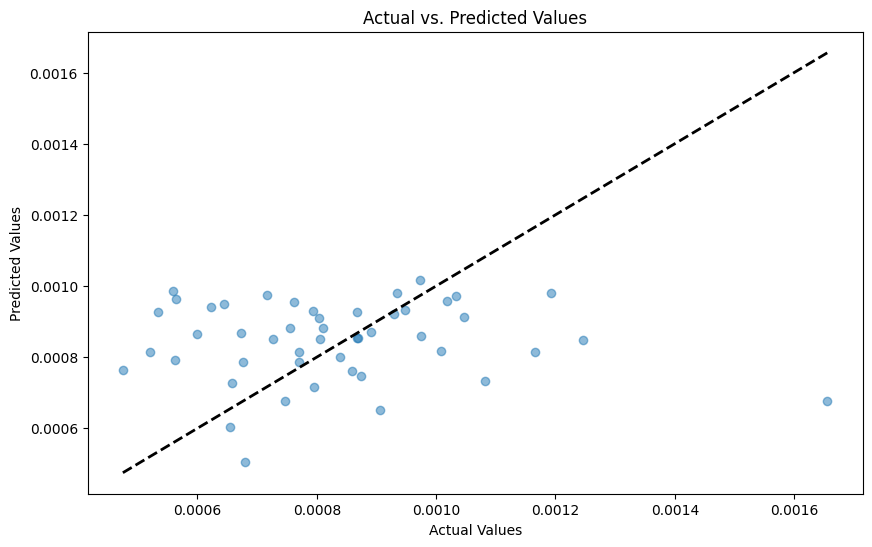

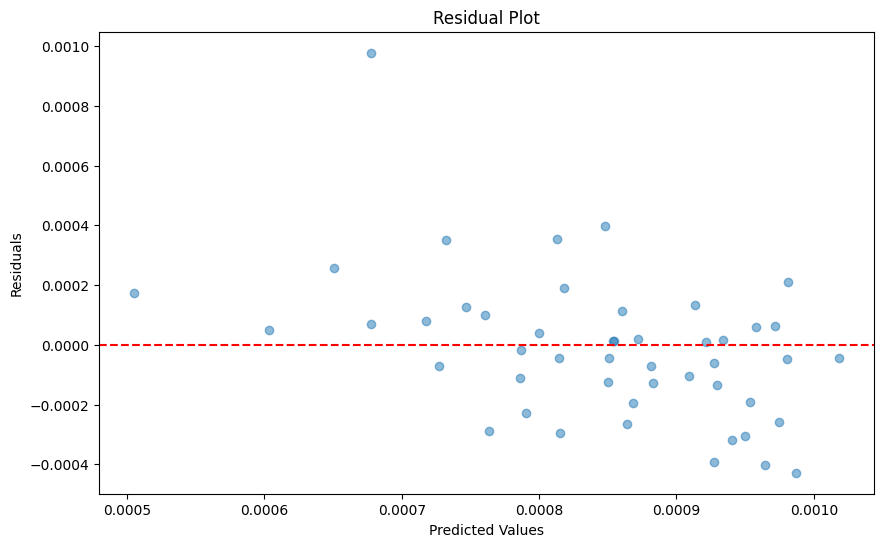

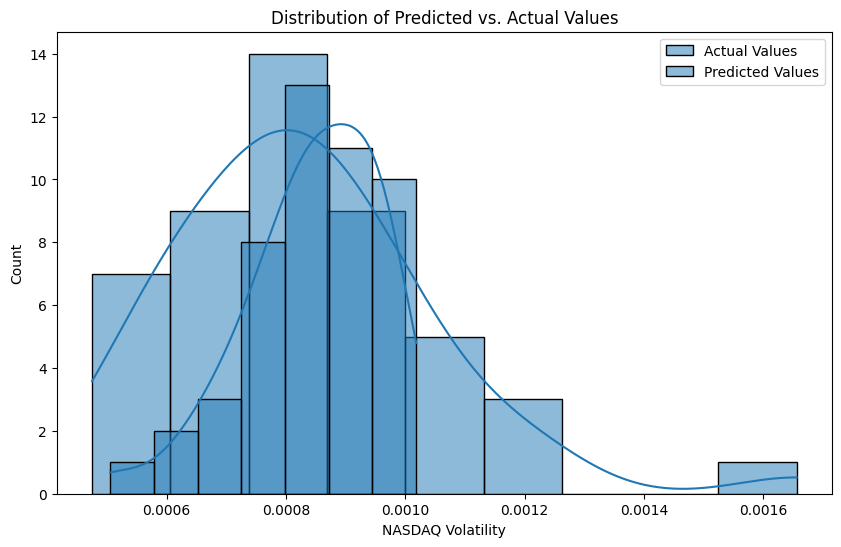

In [253]:
import matplotlib.pyplot as plt
import seaborn as sns
y_pred = predictions
# Actual vs. Predicted Values Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

# Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

# Distribution of Predicted vs. Actual Values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color="blue", label="Actual Values", kde=True)
sns.histplot(y_pred, color="red", label="Predicted Values", kde=True)
plt.title('Distribution of Predicted vs. Actual Values')
plt.xlabel('NASDAQ Volatility')
plt.legend()
plt.show()
